In [1]:
import numpy as np
import pandas as pd
import pyabf
import matplotlib.pyplot as plt

In [118]:
abf = pyabf.ABF('/Users/codycombs/Documents/data/bacteria_rp/raw/pet409/ecoli/abf/raw.abf')

In [119]:
print(abf)

ABF (v2.9) with 2 channels (nA, V), sampled at 10.0 kHz, containing 1 sweep, having no tags, with a total length of 11.51 minutes, recorded with protocol "gapfree 60min".


In [120]:
abf.setSweep(0)
i = abf.sweepY
v = abf.sweepC
t = abf.sweepX

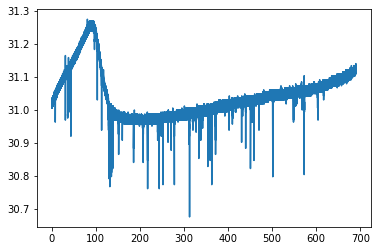

In [121]:
plt.plot(t,i)

In [124]:
events = pd.read_excel('/Users/codycombs/Documents/data/bacteria_rp/raw/pet409/ecoli/csv/events.xlsx')
events = events.drop(events.columns[:4],axis=1)
columns = events.columns
events = events.rename({columns[0]:'t0',columns[1]:'t1',columns[2]:'delta_t',columns[3]:'area',
                        columns[4]:'delta_i',columns[5]:'base_i',columns[6]:'delta_i_i'},axis=1)
events = events.dropna()
events.t0 = np.around(events.t0/1000.,decimals=4)
events.t1 = np.around(events.t1/1000.,decimals=4)
print(len(events))

60


In [125]:
args = []
i_events = []
velocity = []
t_events = []

for j,row in events.iterrows():
    
    arg = np.where((t>=row.t0)&(t<=row.t1))[0]
    
    i_raw = i[arg]
    i_clean = np.abs(i_raw)-np.abs(row.base_i)
    time = t[arg]
    
    vel = (12.*10**(-6))/(row.delta_t/1000.)
    
    i_events.append(i_clean)
    t_events.append(time)
    velocity.append(vel)
    args.append(arg)
    
events['args'] = args
events['i'] = i_events
events['t'] = t_events
events['vel'] = velocity

In [126]:
events.columns

Index(['t0', 't1', 'delta_t', 'area', 'delta_i', 'base_i', 'delta_i_i', 'args',
       'i', 't', 'vel'],
      dtype='object')

In [127]:
base_path = '/Users/codycombs/Documents/data/bacteria_rp/analysis/ecoli/event_plots/'

for j, row in events.iterrows():
    
    plt.plot(row.t,row.i)
    plt.xlabel('Time (s)')
    plt.ylabel('Current (nA)')
    plt.title('E. Coli. Events')
    plt.tight_layout()
    plt.savefig(base_path+'ecoli_'+str(j))
    plt.close()

In [128]:
base_path = '/Users/codycombs/Documents/data/bacteria_rp/analysis/ecoli/dataframe/'
events.to_pickle(base_path+'df_processed.pkl')